# Test ML Classifiers for Fractured Images

## Imports and File Paths

In [28]:
N_POS = 100
N_NEG = 100

SEED = 8


In [50]:
import os, random, glob, math
import numpy as np
import pandas as pd
import cv2
from skimage import exposure, feature, filters, morphology, measure, color
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score, 
                             f1_score, precision_recall_curve, roc_curve, confusion_matrix,
                             precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from pathlib import Path

# XGBoost (install if missing)
try:
    from xgboost import XGBClassifier
except Exception as e:
    XGBClassifier = None
    print("XGBoost not available. Install with `pip install xgboost` to enable that model.")
    
random.seed(SEED)
np.random.seed(SEED)

## Load in Images into Data Frame

In [30]:
# Project-relative roots (no leading slash!)
IMAGE_ROOT = Path("FracAtlas") / "images"
POS_DIR = IMAGE_ROOT / "Fractured"
NEG_DIR = IMAGE_ROOT / "Non_fractured"

print("POS_DIR:", POS_DIR.resolve(), "exists?", POS_DIR.exists())
print("NEG_DIR:", NEG_DIR.resolve(), "exists?", NEG_DIR.exists())

pos_sample = [str(p) for p in POS_DIR.rglob("*") if p.suffix.lower() == ".jpg"][:5]
neg_sample = [str(p) for p in NEG_DIR.rglob("*") if p.suffix.lower() == ".jpg"][:5]

print("Fractured sample:", pos_sample)
print("Non-fractured sample:", neg_sample)

def list_jpgs(root: Path):
    return sorted(str(p) for p in root.rglob("*.jpg")) + \
           sorted(str(p) for p in root.rglob("*.JPG"))

pos_files = list_jpgs(POS_DIR)
neg_files = list_jpgs(NEG_DIR)
print('Found', len(pos_files), 'fractured and', len(neg_files), 'non-fractured images')


POS_DIR: C:\Users\rohan\Duke Stuff\BME790\Bone-Fracture-AI-Analysis\FracAtlas\images\Fractured exists? True
NEG_DIR: C:\Users\rohan\Duke Stuff\BME790\Bone-Fracture-AI-Analysis\FracAtlas\images\Non_fractured exists? True
Fractured sample: ['FracAtlas\\images\\Fractured\\IMG0000019.jpg', 'FracAtlas\\images\\Fractured\\IMG0000025.jpg', 'FracAtlas\\images\\Fractured\\IMG0000044.jpg', 'FracAtlas\\images\\Fractured\\IMG0000057.jpg', 'FracAtlas\\images\\Fractured\\IMG0000058.jpg']
Non-fractured sample: ['FracAtlas\\images\\Non_fractured\\IMG0000000.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000001.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000002.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000003.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000004.jpg']
Found 1434 fractured and 6732 non-fractured images


In [31]:
pos_sel = random.sample(pos_files, k=min(N_POS, len(pos_files)))
neg_sel = random.sample(neg_files, k=min(N_NEG, len(neg_files)))

work_df = pd.DataFrame({
    'image_path': pos_sel + neg_sel,
    'label': [1]*len(pos_sel) + [0]*len(neg_sel),
})
work_df = work_df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print('Subset size:', len(work_df),
      ' (pos:', (work_df['label']==1).sum(),
      ', neg:', (work_df['label']==0).sum(), ')')
work_df.head()


Subset size: 200  (pos: 100 , neg: 100 )


,image_path,label
0,FracAtlas\images\Fractured\IMG0002420.jpg,1
1,FracAtlas\images\Fractured\IMG0002934.jpg,1
2,FracAtlas\images\Non_fractured\IMG0001503.jpg,0
3,FracAtlas\images\Non_fractured\IMG0003533.jpg,0
4,FracAtlas\images\Fractured\IMG0000156.jpg,1


## Preprocessing and Feature Extraction

In [41]:
TARGET_SIZE = (512, 512) 

def load_gray(path, target_size=TARGET_SIZE):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # --- pad to square so aspect differences don't change HOG dimensions ---
    h, w = img.shape
    side = max(h, w)
    pad_top    = (side - h) // 2
    pad_bottom = side - h - pad_top
    pad_left   = (side - w) // 2
    pad_right  = side - w - pad_left

    img_sq = cv2.copyMakeBorder(
        img, pad_top, pad_bottom, pad_left, pad_right,
        borderType=cv2.BORDER_REFLECT_101  # safe mirror padding for medical images
    )

    # --- now resize to a fixed size (e.g., 512x512) ---
    img_fixed = cv2.resize(img_sq, target_size, interpolation=cv2.INTER_AREA)
    return img_fixed

def bg_suppress_and_stretch(img, t=30):
    """
    Push all pixels <= t to 0 (background), and linearly stretch the rest
    into 1..255 (reserve 0 for background). Also returns a body mask.
    """
    img16 = img.astype(np.int16)
    body_mask = img16 > t

    out = np.zeros_like(img16, dtype=np.uint8)
    hi_start = t + 1
    if hi_start < 255 and body_mask.any():
        scale = 254.0 / (255 - hi_start)  # map [hi_start..255] -> [1..255]
        vals = img16[body_mask]
        out_vals = 1 + np.round((vals - hi_start) * scale)
        out_vals = np.clip(out_vals, 1, 255)
        out[body_mask] = out_vals.astype(np.uint8)

    return out, body_mask


def high_pass_dog(img, sigma1=1.0, sigma2=3.0):
    # Difference of Gaussians as a band-pass / high-pass approximation
    g1 = cv2.GaussianBlur(img, (0,0), sigma1)
    g2 = cv2.GaussianBlur(img, (0,0), sigma2)
    hp = cv2.subtract(g1, g2)
    return cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX)

def laplacian_var(img):
    lap = cv2.Laplacian(img, cv2.CV_32F, ksize=3)
    return float(lap.var())

def canny_edges(img, lo=50, hi=150):
    edges = cv2.Canny(img, lo, hi, L2gradient=True)
    return edges

def hpf_energy(hp):
    f = hp.astype(np.float32) / 255.0
    return float((f**2).mean())

def edge_density(edges):
    return float(edges.mean() / 255.0)

def hog_features(img, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9):
    # skimage hog returns feature vector
    f = feature.hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=False, feature_vector=True)
    return f

def lbp_hist(img, P=8, R=1):
    lbp = feature.local_binary_pattern(img, P=P, R=R, method='uniform')
    # Uniform LBP has P+2 bins
    n_bins = P + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist


def extract_features(img):
    # Ensure fixed size for consistent HOG length
    if img.shape[:2] != TARGET_SIZE:
        img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

    # Background suppression + stretch
    img_s, mask = bg_suppress_and_stretch(img, t=20)

    # Optional: light CLAHE but re-apply mask afterwards to avoid background lift
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_c = clahe.apply(img_s)
    img_c[~mask] = 0

    # High-pass (DoG) and edges INSIDE the mask
    hp  = high_pass_dog(img_c, sigma1=1.0, sigma2=3.0)
    hp[~mask] = 0

    edges = canny_edges(img_c, lo=40, hi=120)
    edges[~mask] = 0

    # Scalars
    feats = [
        laplacian_var(img_c),
        hpf_energy(hp),
        edge_density(edges),
        float(img_c[mask].mean() if mask.any() else 0.0),
        float(img_c[mask].std()  if mask.any() else 0.0),
    ]

    # HOG/LBP (computed on masked image to avoid background bias)
    hog_f  = hog_features(img_c, pixels_per_cell=(16,16), cells_per_block=(2,2), orientations=9)
    lbp_f1 = lbp_hist(img_c, P=8,  R=1)
    lbp_f2 = lbp_hist(img_c, P=16, R=2)

    return np.hstack([feats, hog_f, lbp_f1, lbp_f2])


### Build Feature Matrix

In [42]:
# Build feature matrix X and labels y
X_list = []
y_list = []

for _, row in work_df.iterrows():
    img = load_gray(row['image_path'])
    if img is None:
        continue
    f = extract_features(img)
    X_list.append(f)
    y_list.append(int(row['label']))

X = np.vstack(X_list)
y = np.array(y_list)
print('X shape:', X.shape, ' | y:', y.shape, ' | positives:', y.sum())

X shape: (200, 34629)  | y: (200,)  | positives: 100


## Train Test Split (80/20)

In [34]:

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.20, random_state=SEED, stratify=y)

print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (160, 34629) Test: (40, 34629)


## Running 2 Models with cross validation

In [49]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Small, fast grids (tweak if you want more search)
rf_grid = [
    dict(n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1),
    dict(n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1),
    dict(n_estimators=800, max_depth=20,  min_samples_split=2, min_samples_leaf=1),
]

xgb_grid = []
pos = y.sum()
neg = len(y) - pos
if XGBClassifier is not None and pos > 0:
    spw = max(1.0, neg / max(1, pos))  # scale_pos_weight
    xgb_grid = [
        dict(n_estimators=400, max_depth=3, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, scale_pos_weight=spw),
        dict(n_estimators=600, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, scale_pos_weight=spw),
    ]

def cv_score_rf(params):
    aucs, aprs = [], []
    for tr, va in skf.split(X, y):
        m = RandomForestClassifier(
            **params,
            class_weight='balanced',
            random_state=SEED,
            n_jobs=-1
        )
        m.fit(X[tr], y[tr])
        p = m.predict_proba(X[va])[:,1]
        aucs.append(roc_auc_score(y[va], p))
        aprs.append(average_precision_score(y[va], p))
    return np.mean(aucs), np.std(aucs), np.mean(aprs)

def cv_score_xgb(params):
    aucs, aprs = [], []
    for tr, va in skf.split(X, y):
        m = XGBClassifier(
            eval_metric='logloss',
            objective='binary:logistic',
            random_state=SEED,
            n_jobs=-1,
            **params
        )
        m.fit(X[tr], y[tr])
        p = m.predict_proba(X[va])[:,1]
        aucs.append(roc_auc_score(y[va], p))
        aprs.append(average_precision_score(y[va], p))
    return np.mean(aucs), np.std(aucs), np.mean(aprs)

# ---- Run CV for both model families ----
results = []

for g in rf_grid:
    mean_auc, std_auc, mean_ap = cv_score_rf(g)
    results.append(("RF", g, mean_auc, std_auc, mean_ap))

if xgb_grid:
    for g in xgb_grid:
        mean_auc, std_auc, mean_ap = cv_score_xgb(g)
        results.append(("XGB", g, mean_auc, std_auc, mean_ap))

# Rank by mean AUROC
results = sorted(results, key=lambda r: r[2], reverse=True)

print("Cross-validated results (top first):")
for algo, params, mean_auc, std_auc, mean_ap in results:
    print(f"{algo} | AUROC {mean_auc:.3f} ± {std_auc:.3f} | AUPRC {mean_ap:.3f} | params={params}")

# ---- Pick best and refit on ALL data ----
best_algo, best_params, best_auc, _, best_ap = results[0]
print(f"\nBEST: {best_algo} with AUROC {best_auc:.3f}, AUPRC {best_ap:.3f}")

if best_algo == "RF":
    final_model = RandomForestClassifier(
        **best_params,
        class_weight='balanced',
        random_state=SEED,
        n_jobs=-1
    )
else:
    final_model = XGBClassifier(
        eval_metric='logloss',
        objective='binary:logistic',
        random_state=SEED,
        n_jobs=-1,
        **best_params
    )

final_model.fit(X, y)  # trained on ALL ~200 samples

# Optional: get out-of-fold predictions for curves/plots
oof = np.zeros(len(y), dtype=float)
for tr, va in skf.split(X, y):
    if best_algo == "RF":
        m = RandomForestClassifier(
            **best_params, class_weight='balanced', random_state=SEED, n_jobs=-1
        )
    else:
        m = XGBClassifier(
            eval_metric='logloss', objective='binary:logistic',
            random_state=SEED, n_jobs=-1, **best_params
        )
    m.fit(X[tr], y[tr])
    oof[va] = m.predict_proba(X[va])[:,1]

print("\nOOF AUROC:", roc_auc_score(y, oof))
print("OOF AUPRC:", average_precision_score(y, oof))

Cross-validated results (top first):
XGB | AUROC 0.779 ± 0.059 | AUPRC 0.795 | params={'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'scale_pos_weight': 1.0}
XGB | AUROC 0.777 ± 0.051 | AUPRC 0.798 | params={'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'scale_pos_weight': 1.0}
RF | AUROC 0.775 ± 0.040 | AUPRC 0.795 | params={'n_estimators': 800, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
RF | AUROC 0.775 ± 0.044 | AUPRC 0.791 | params={'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
RF | AUROC 0.774 ± 0.043 | AUPRC 0.795 | params={'n_estimators': 300, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}

BEST: XGB with AUROC 0.779, AUPRC 0.795

OOF AUROC: 0.7728999999999999
OOF AUPRC: 0.7847657095521506


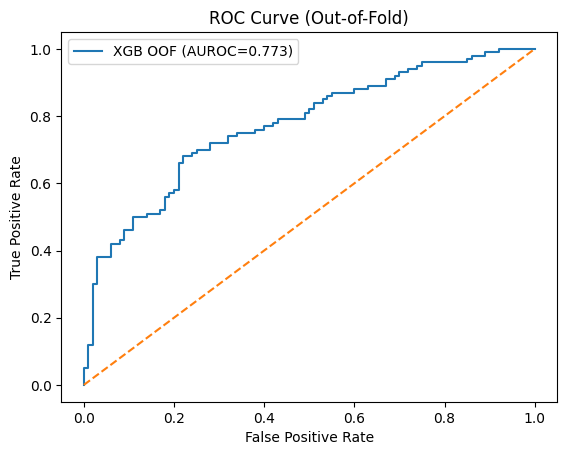

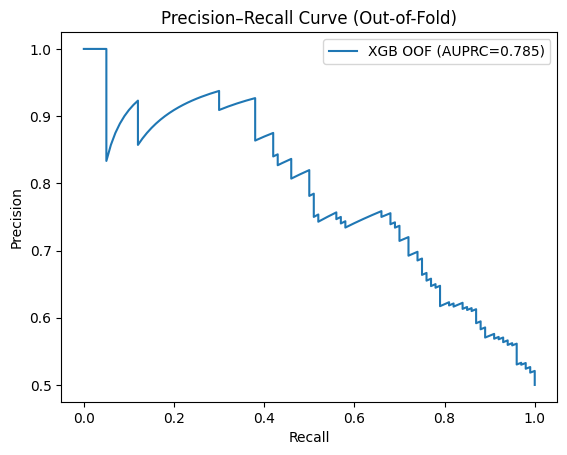

In [51]:
# oof : out-of-fold probabilities for the BEST model (computed in the CV block)
# y   : true labels for all samples

auroc_oof = roc_auc_score(y, oof)
auprc_oof = average_precision_score(y, oof)

# ROC
plt.figure()
fpr, tpr, _ = roc_curve(y, oof)
plt.plot(fpr, tpr, label=f'{best_algo} OOF (AUROC={auroc_oof:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve (Out-of-Fold)')
plt.legend()
plt.show()

# PR
plt.figure()
prec, rec, _ = precision_recall_curve(y, oof)
plt.plot(rec, prec, label=f'{best_algo} OOF (AUPRC={auprc_oof:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall Curve (Out-of-Fold)')
plt.legend()
plt.show()

## Threshold metrics and confusion matrix 

In [52]:
def summarize_threshold(proba, y_true, thr=None):
    if thr is None:
        # pick threshold that maximizes F1
        best_f1, best_thr = -1.0, 0.5
        for t in np.linspace(0.05, 0.95, 19):
            yhat = (proba >= t).astype(int)
            f1 = f1_score(y_true, yhat, zero_division=0)
            if f1 > best_f1:
                best_f1, best_thr = f1, t
        thr = best_thr

    yhat = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, yhat)
    acc = accuracy_score(y_true, yhat)
    f1  = f1_score(y_true, yhat, zero_division=0)
    prec = precision_score(y_true, yhat, zero_division=0)
    rec  = recall_score(y_true, yhat, zero_division=0)  # sensitivity
    # specificity = TN / (TN + FP)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return thr, acc, f1, prec, rec, spec, cm

# Use OOF probs from the BEST model selected in CV
thr, acc, f1, prec, rec, spec, cm = summarize_threshold(oof, y)

print(f"Best model: {best_algo}")
print(f"thr={thr:.2f} | acc={acc:.3f} | f1={f1:.3f} | precision={prec:.3f} | recall(sens)={rec:.3f} | specificity={spec:.3f}")
print("Confusion matrix [TN FP; FN TP]:\n", cm)

Best model: XGB
thr=0.45 | acc=0.705 | f1=0.718 | precision=0.688 | recall(sens)=0.750 | specificity=0.660
Confusion matrix [TN FP; FN TP]:
 [[66 34]
 [25 75]]


## Localization Attempt

In [54]:
def localize_fracture_region(img, hp_sigma1=1.0, hp_sigma2=3.0, min_area=30, max_frac_radius=0.45):
    """
    Post-hoc localization:
    - background-suppress + stretch
    - masked DoG -> Otsu -> clean -> rank components
    - draw yellow min-enclosing circle with radius cap
    """
    img_s, mask = bg_suppress_and_stretch(img, t=20)

    # Gentle CLAHE, then reinstate mask
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_c = clahe.apply(img_s)
    img_c[~mask] = 0

    # High-pass inside mask
    hp = high_pass_dog(img_c, sigma1=hp_sigma1, sigma2=hp_sigma2)
    hp[~mask] = 0
    hp_u8 = cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Threshold only where mask is True
    thr = filters.threshold_otsu(hp_u8[mask]) if mask.any() else 255
    m = np.zeros_like(hp_u8, dtype=np.uint8)
    m[(hp_u8 >= thr) & mask] = 255

    # Morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN, kernel, iterations=1)
    m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel, iterations=1)

    labeled = measure.label(m > 0, connectivity=2)
    props = measure.regionprops(labeled)
    if not props:
        overlay = cv2.cvtColor(img_c, cv2.COLOR_GRAY2BGR)
        return overlay, None, None

    # Rank by area * eccentricity * mean hp intensity (favor thin energetic lines)
    def score(p):
        rr, cc = p.coords[:,0], p.coords[:,1]
        return p.area * max(p.eccentricity, 0.5) * float(hp_u8[rr, cc].mean())

    props = sorted(props, key=score, reverse=True)
    best = next((p for p in props if p.area >= min_area), props[0])

    pts = np.array(best.coords)[:, ::-1].astype(np.int32)  # (x,y)
    (cx, cy), radius = cv2.minEnclosingCircle(pts.reshape(-1,1,2))

    # Cap the circle radius to avoid “giant corner circles”
    h, w = img.shape
    cap = int(max_frac_radius * min(h, w))
    radius = int(min(radius, cap))
    cx, cy = int(cx), int(cy)

    overlay = cv2.cvtColor(img_c, cv2.COLOR_GRAY2BGR)
    cv2.circle(overlay, (cx, cy), radius, (0,255,255), 2)
    return overlay, (cx, cy), radius

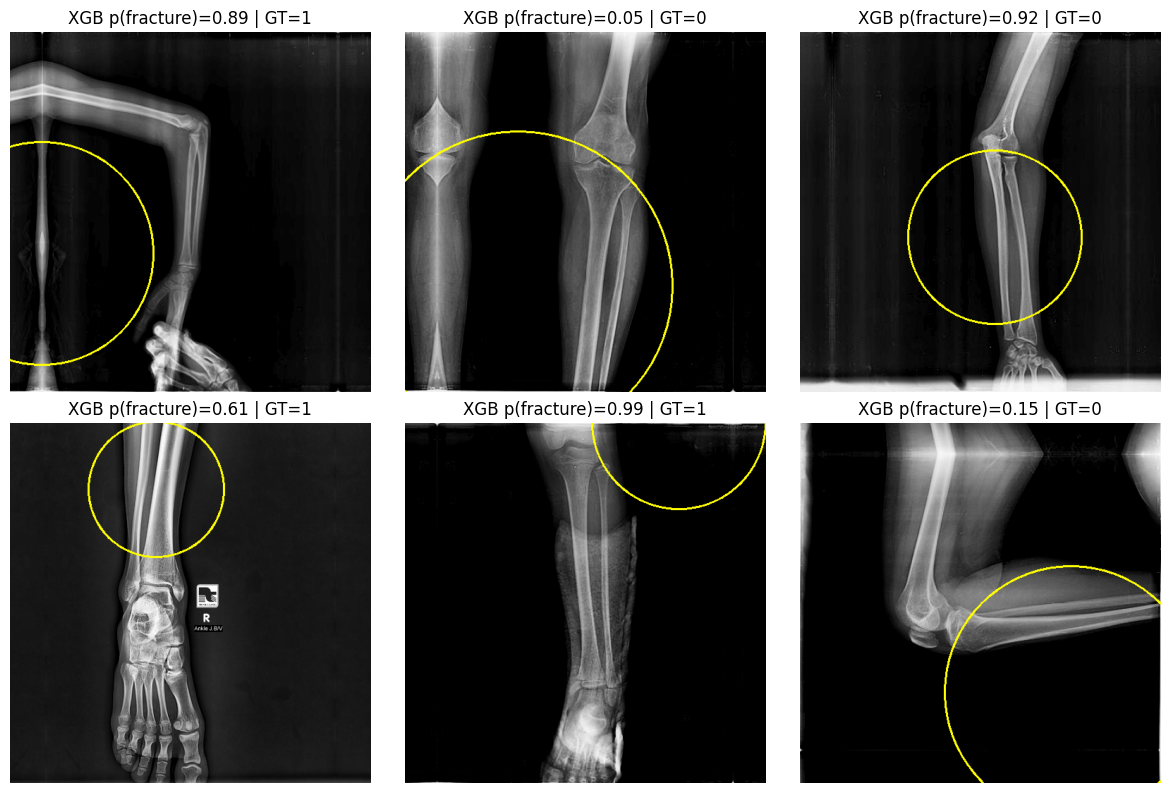

In [55]:
n_show = 6
sel = np.random.choice(len(y), size=min(n_show, len(y)), replace=False)

plt.figure(figsize=(12, 8))
for i, k in enumerate(sel, 1):
    p = float(oof[k])                 # OOF prob from best model
    y_true = int(y[k])                # ground truth
    img = load_gray(work_df.iloc[k]['image_path'])
    overlay, center, radius = localize_fracture_region(img)
    title = f"{best_algo} p(fracture)={p:.2f} | GT={y_true}"
    plt.subplot(2, 3, i)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title(title)
plt.tight_layout(); plt.show()

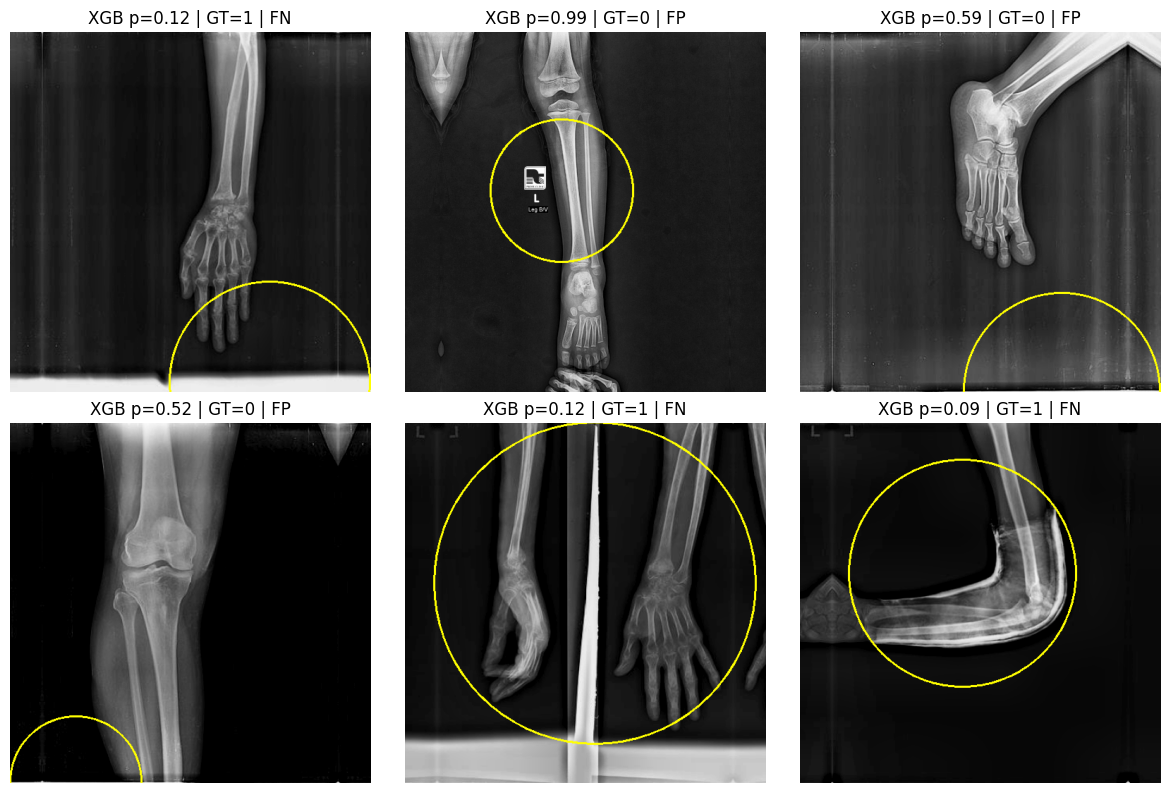

In [56]:
# Sort by model confidence
order = np.argsort(oof)  # low → high
low_idx  = order[:3]      # likely negatives
high_idx = order[-3:]     # likely positives

# Identify some mistakes at the F1-optimal threshold
thr, *_ = summarize_threshold(oof, y, thr=None)
pred = (oof >= thr).astype(int)
fp_idx = np.where((pred == 1) & (y == 0))[0][:3]  # false positives
fn_idx = np.where((pred == 0) & (y == 1))[0][:3]  # false negatives

show_idx = np.unique(np.concatenate([high_idx, low_idx, fp_idx, fn_idx]))[:6]

plt.figure(figsize=(12, 8))
for i, k in enumerate(show_idx, 1):
    p = float(oof[k]); y_true = int(y[k])
    img = load_gray(work_df.iloc[k]['image_path'])
    overlay, center, radius = localize_fracture_region(img)
    err = ""
    if   (pred[k] == 1 and y[k] == 0): err = " | FP"
    elif (pred[k] == 0 and y[k] == 1): err = " | FN"
    title = f"{best_algo} p={p:.2f} | GT={y_true}{err}"
    plt.subplot(2, 3, i)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title(title)
plt.tight_layout(); plt.show()